# Thresholding tests
In marker recognition thresholding correctly the image is primarily for a correct detecting marker type and content.\
In this code we will try cv2.adaptiveThreshold tuning the parameters for a right interpretation of markers themself.

In [1]:
# Import libraries once
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
%run ../general-utility.ipynb

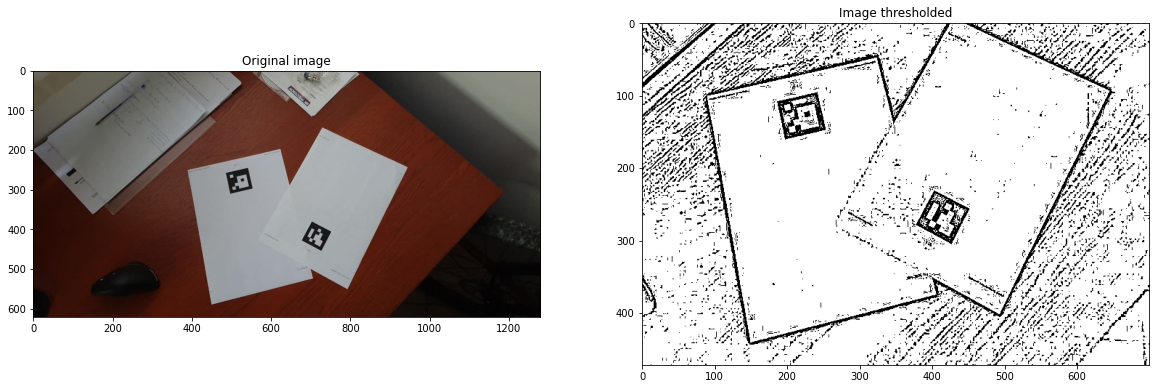

In [2]:
# Read the image with the markers
queryImg = cv2.imread("test-imgs/two-A4-merged.jpg")

# Generate grayscale image
grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)

imgThresh_1 = cv2.adaptiveThreshold(grayQueryImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Show result and zoom on aruco
show_two_imgs(queryImg, "Original image", imgThresh_1[150:,300:1000], "Image thresholded")

First result shows that markers cannot be recognized, due to the absence of the black contour and some black areas of sensitive pixels themself, as pointed out in nex cell. Also some filtering is needed in order to get a better thresholding result.

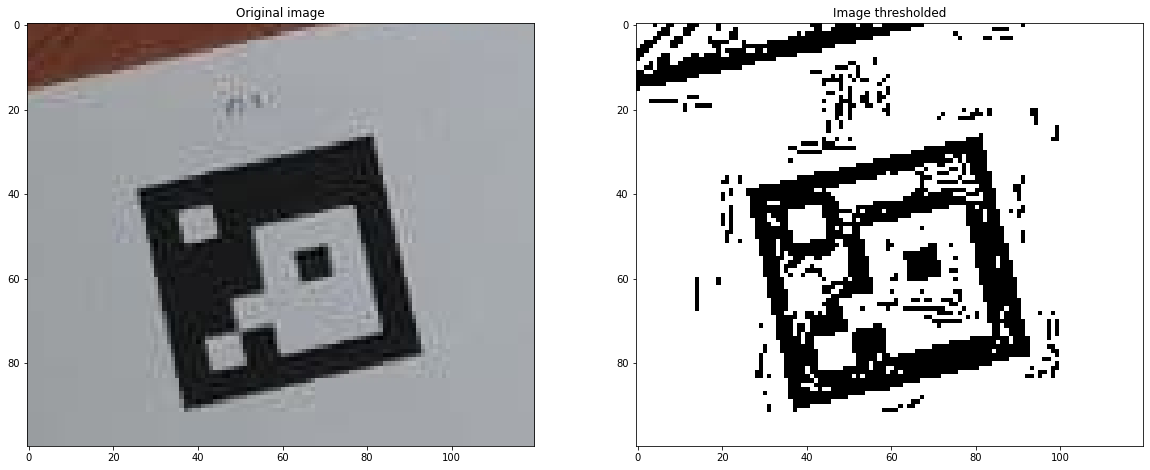

In [3]:
show_two_imgs(queryImg[220:320,460:580], "Original image", imgThresh_1[220:320,460:580], "Image thresholded")

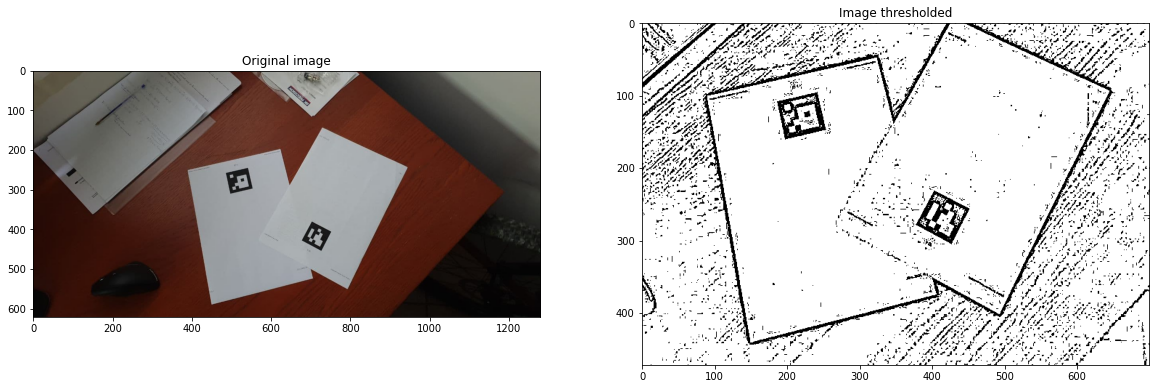

In [4]:
# Adding blurring
blurImg = cv2.GaussianBlur(grayQueryImg, (9, 9), 0.5)

imgThresh_2 = cv2.adaptiveThreshold(blurImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

show_two_imgs(queryImg, "Original image", imgThresh_2[150:,300:1000], "Image thresholded")

With gaussian blur it seems we obtained a better result but markers still cannot be corretly read. We can enlight the changes between the two images, before and after the filtering stage:

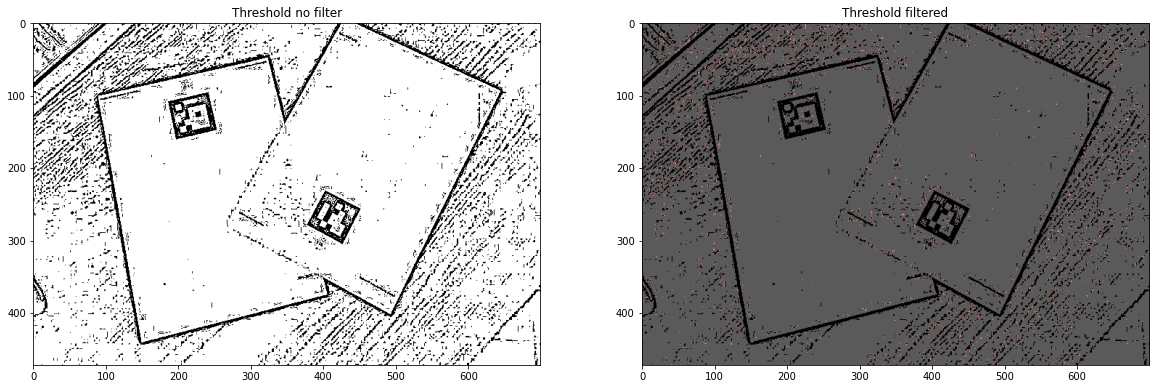

In [5]:
imgThresh_diff = imgThresh_2[150:,300:1000] - imgThresh_1[150:,300:1000]
# Get back to color to enlight in red differences
imgThresh_showDiff = cv2.cvtColor(imgThresh_2[150:,300:1000], cv2.COLOR_GRAY2BGR)

imgThresh_showDiff[imgThresh_showDiff > 200] = 90 # Darken the image to get better visual impact
# Color difference pixels as BGR (130,130,255)
imgThresh_showDiff[imgThresh_diff == 255, 0] = 130
imgThresh_showDiff[imgThresh_diff == 255, 1] = 130
imgThresh_showDiff[imgThresh_diff == 255, 2] = 255
show_two_imgs(imgThresh_1[150:,300:1000], "Threshold no filter", imgThresh_showDiff, "Threshold filtered")

In the adaptiveThreshold function many parameters can be configured:
1. **ADAPTIVE_THRESH_MEAN_C** or **ADAPTIVE_THRESH_GAUSSIAN_C**
2. **thresholdType** : a variable of integer type representing the type of threshold to be used
3. **blockSize** : a variable of the integer type representing size of the pixelneighborhood used to calculate the threshold value;
4. **C** : a variable of double type representing the constant used in the both methods (subtracted from the mean or weighted mean).

In next cell we changed to a ADAPTIVE_THRESH_MEAN_C instead of gaussian. We also enlarged the block size to 21:

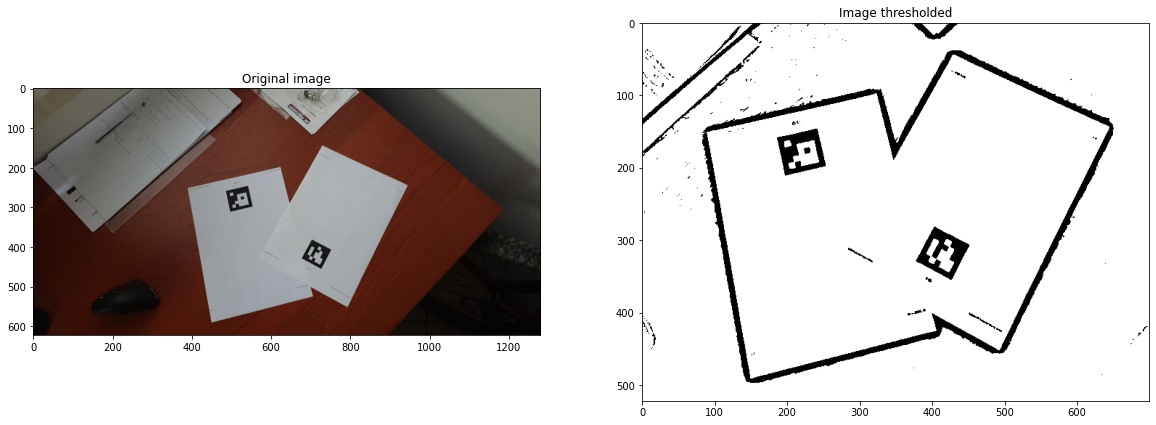

In [6]:
blurImg = cv2.GaussianBlur(grayQueryImg, (7, 7), 0.5)

imgThresh_3 = cv2.adaptiveThreshold(blurImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

show_two_imgs(queryImg, "Original image", imgThresh_3[100:,300:1000], "Image thresholded")

We see now that the two markers can be correctly parsed, in fact all the internal 5x5 matrix is preserved: aruco-pixels are correctly white or black.

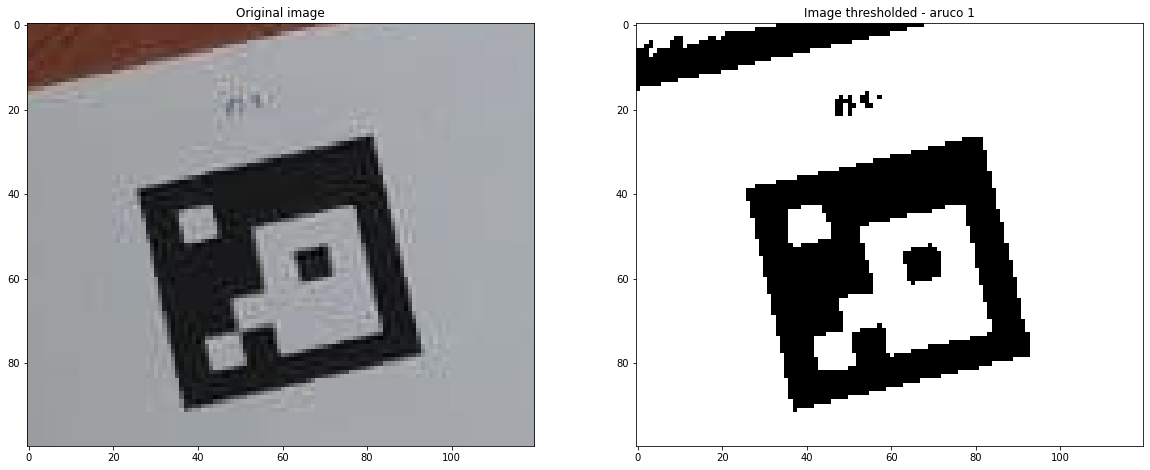

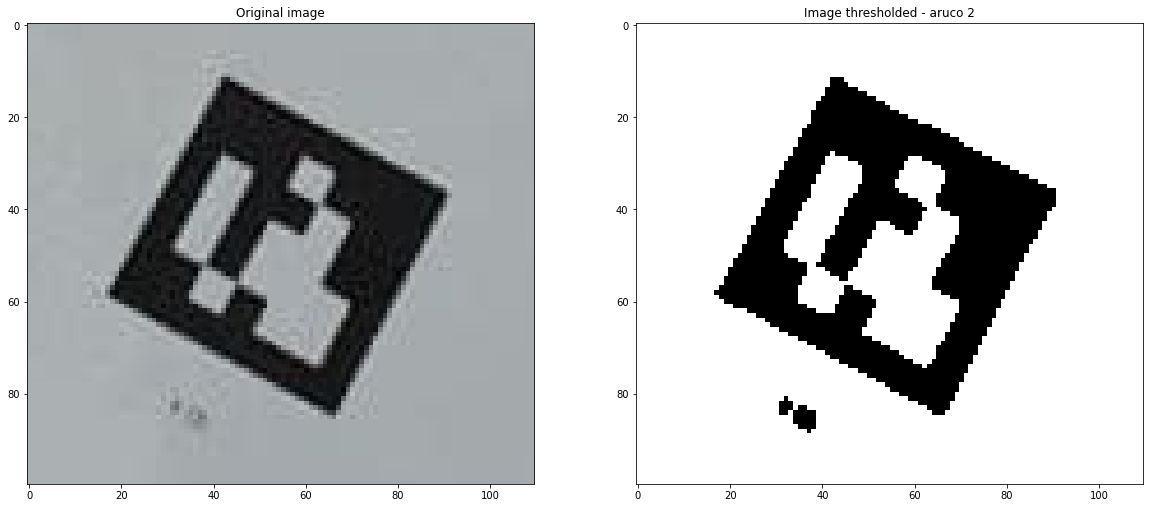

In [7]:
show_two_imgs(queryImg[220:320,460:580], "Original image", imgThresh_3[220:320,460:580], "Image thresholded - aruco 1")
show_two_imgs(queryImg[370:470,660:770], "Original image", imgThresh_3[370:470,660:770], "Image thresholded - aruco 2")

This works well with small aruco relative to the overall image size, but led to problems if the aruco becomes bigger, as in the code below:

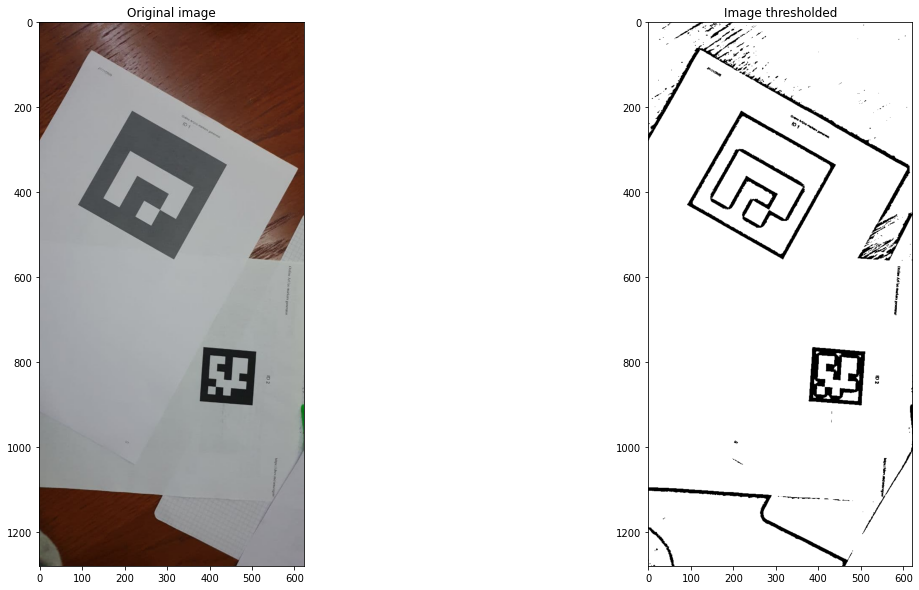

In [8]:
queryImg_2 = cv2.imread("test-imgs/two-aruco-types.jpg")

# Generate grayscale image
grayQueryImg_2 = cv2.cvtColor(queryImg_2, cv2.COLOR_BGR2GRAY)
blurImg_2 = cv2.GaussianBlur(grayQueryImg_2, (7, 7), 0.5)

imgThresh_4 = cv2.adaptiveThreshold(blurImg_2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

show_two_imgs(queryImg_2, "Original image", imgThresh_4, "Image thresholded")

Black pixels inside the aruco are not correctly interpreted as black and so they are not recognized by the function.\
We can surely increase the block size to get the threshold work with bigger aruco ...

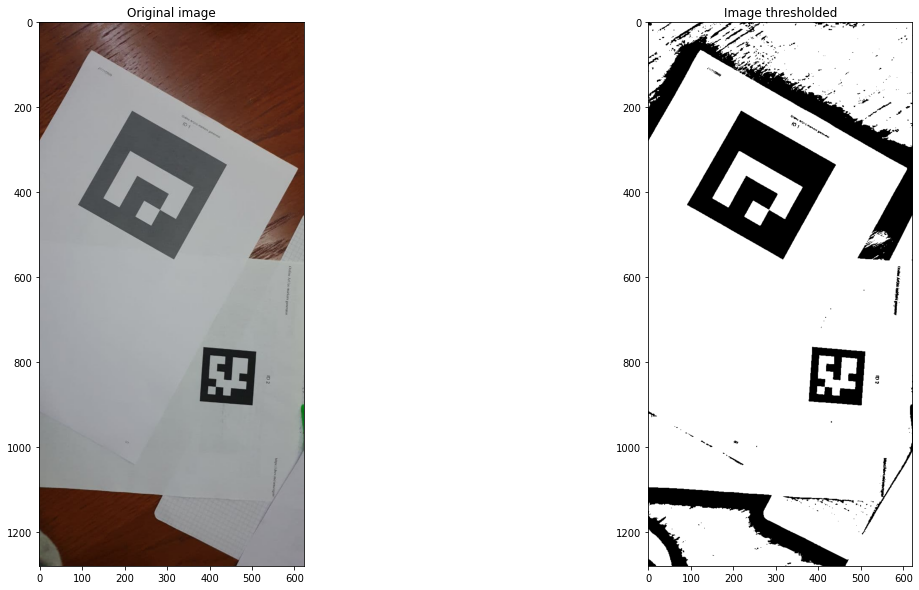

In [9]:
imgThresh_5 = cv2.adaptiveThreshold(blurImg_2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 91, 7)

show_two_imgs(queryImg_2, "Original image", imgThresh_5, "Image thresholded")

... but we need a value as high as 91 to get a good result. Fortunately this value reacts great also with smaller aruco, with the drawback of many more artifacts that can increase search time.

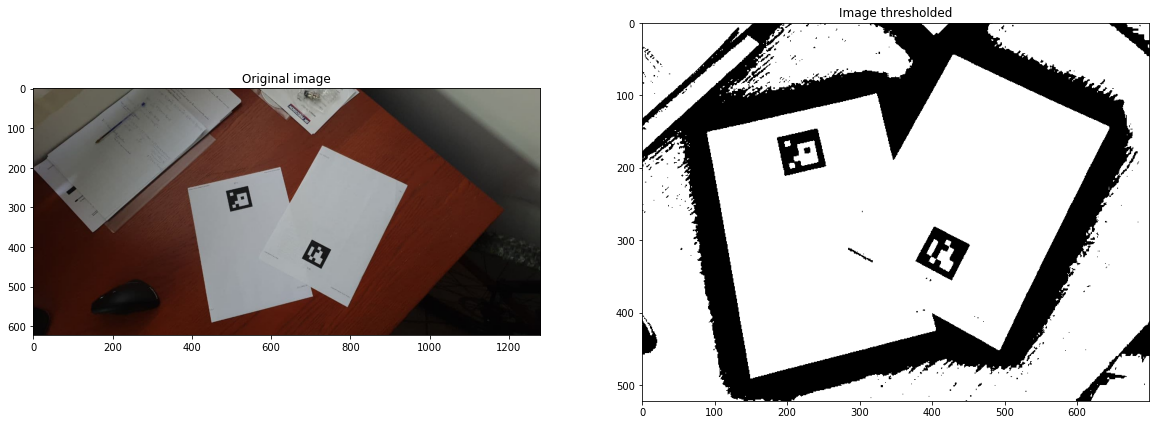

In [10]:
imgThresh_6 = cv2.adaptiveThreshold(blurImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 91, 7)

show_two_imgs(queryImg, "Original image", imgThresh_6[100:,300:1000], "Image thresholded")

The big aruco case analyzed before is not unrealistic for our scenario, because we have to recognise markers from the camera over the robotic arm, that can be very close to the panel, so the marker.

### Conclusion
As pointed out in the official opencv page related to aruco recognition, the solution to both get the advantage of adaptive thresholdind and overcome the block-size problem is to do many thresholding with different parameters, and search for the candidates in each image produced.\
For our needs, we will chose a block-size higher than the one suggested by default configuration, that is adaptiveThreshWinSizeMax = 23 in order to get good results also with bigger aruco.